# chloride module example

In [1]:
%matplotlib inline

from helper_func import *
from chloride import Chloride_Model, load_df_D_RCM, C_crit_param, C_eqv_to_C_S_0


In [12]:
# global
class Wrapper: pass

pars_raw = Wrapper()

pars_raw.marine = False

# 1)marine or coastal
pars_raw.C_0_M = 18.980 # natural chloirde content of sea water [g/l] https://www.lenntech.com/composition-seawater.htm
  
# 2) de icing salt (hard to quantify)
pars_raw.C_0_R = 0  # average chloride content of the chloride contaminated water [g/l]
pars_raw.n = 0      # average number of salting events per year [-]
pars_raw.C_R_i = 0  # average amount of chloride spread within one spreading event [g/m2]
pars_raw.h_S_i = 1  # amount of water from rain and melted snow per spreading period [l/m2]

pars_raw.C_eqv_to_C_S_0 = C_eqv_to_C_S_0

pars_raw.exposure_condition = 'splash'
pars_raw.exposure_condition_geom_sensitive = True
pars_raw.T_real = 273 + 25

pars_raw.x_a = 10.
pars_raw.x_h = 10.
pars_raw.D_RCM_test = 'N/A'
pars_raw.concrete_type = 'Portland cement concrete'
pars_raw.cement_concrete_ratio = 300./2400.
pars_raw.C_max_user_input = None
pars_raw.C_max_option = 'empirical'
pars_raw.C_0 = 0
pars_raw.C_crit_distrib_param = C_crit_param()

pars_raw.option = Wrapper()
pars_raw.option.choose = True
pars_raw.option.cement_type = 'CEM_I_42.5_R+SF'
pars_raw.option.wc_eqv = 0.4
pars_raw.option.df_D_RCM_0 = load_df_D_RCM()

/Users/gangli/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Pf(g = R-S < 0) from various methods
    sample count: 0.52265
    g integral: 0.5254231872318098
    R S integral: 0.5261485329604664
    beta_factor: -0.3115867938031195


<IPython.core.display.Javascript object>


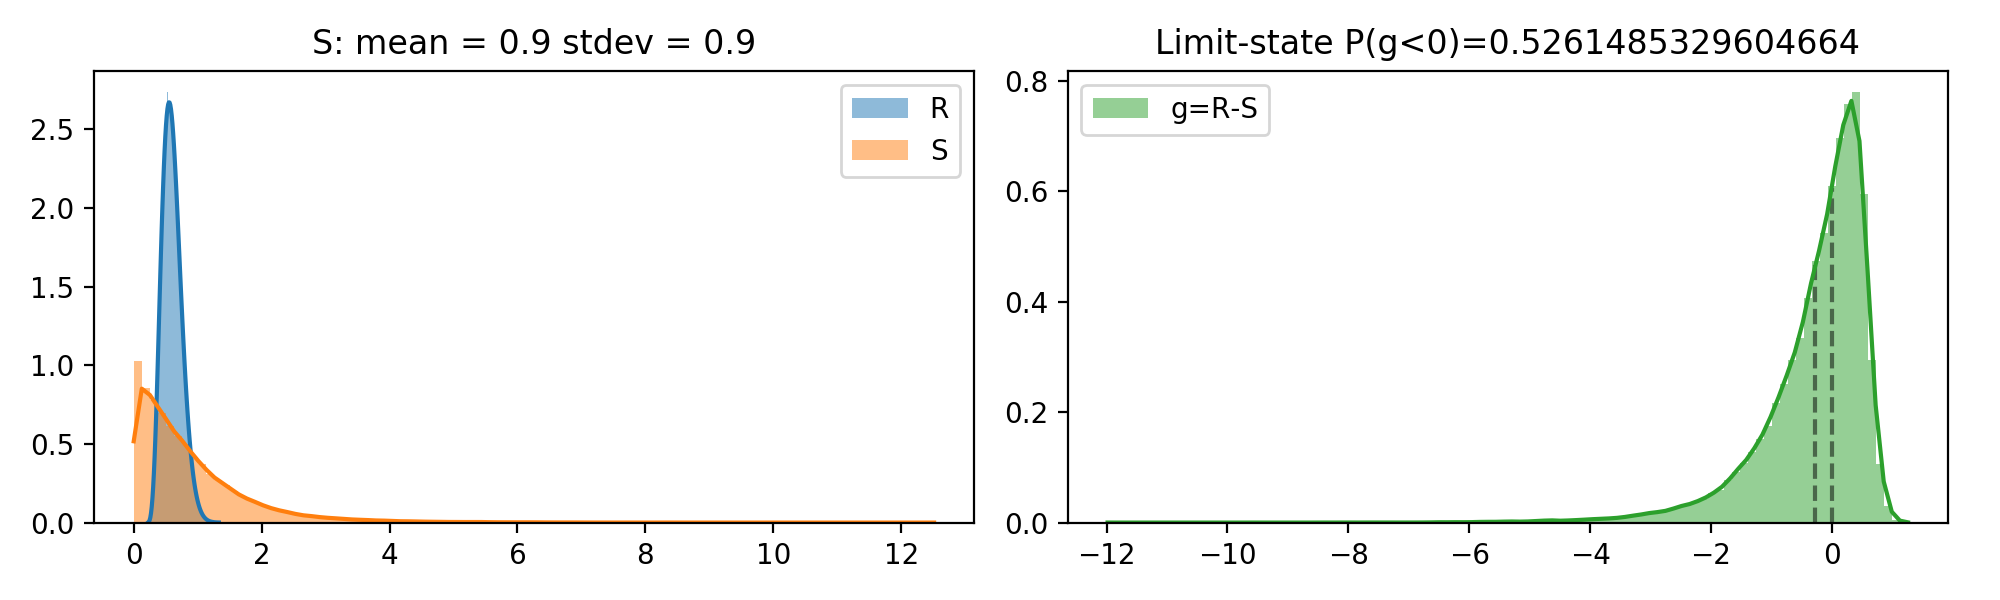

In [13]:
# run model
M = Chloride_Model(pars_raw)
M.run(x = 40, t = 10)
M.postproc(plot=True)

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.2/chloride.py:62: RuntimeWarning: invalid value encountered in sqrt
  C_x_t = pars.C_0 + (pars.C_S_dx - pars.C_0) * (1 - erf((x - pars.dx) / (2 * (pars.D_app * t) ** 0.5)))


2.9077148437500003e-13
1.0100097656250002e-12
2.583251953125e-12


<IPython.core.display.Javascript object>


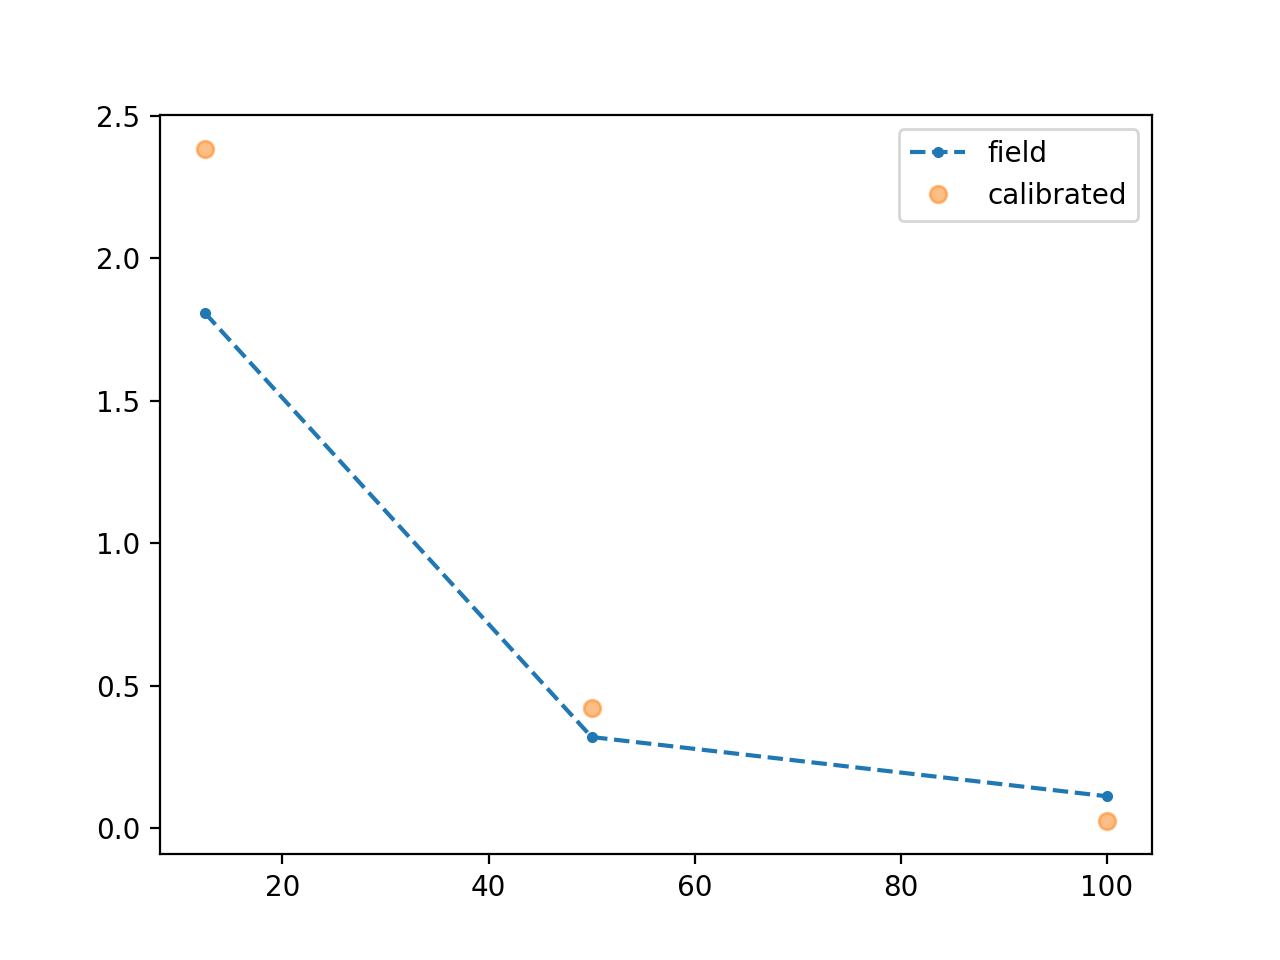

In [14]:
# Calibration
chloride_content_field = pd.DataFrame()
chloride_content_field['depth'] = [12.5, 50, 100]  # [mm]
chloride_content_field['cl'] = np.array([0.226, 0.04, 0.014]) / pars_raw.cement_concrete_ratio  # chloride_content[wt.-%/cement]
M_cal = M.calibrate(40, chloride_content_field,print_proc=False) 

Pf(g = R-S < 0) from various methods
    sample count: 0.23457
    g integral: 0.23588250121225662
    R S integral: 0.23592790179669368
    beta_factor: 0.33564072671782746


<IPython.core.display.Javascript object>


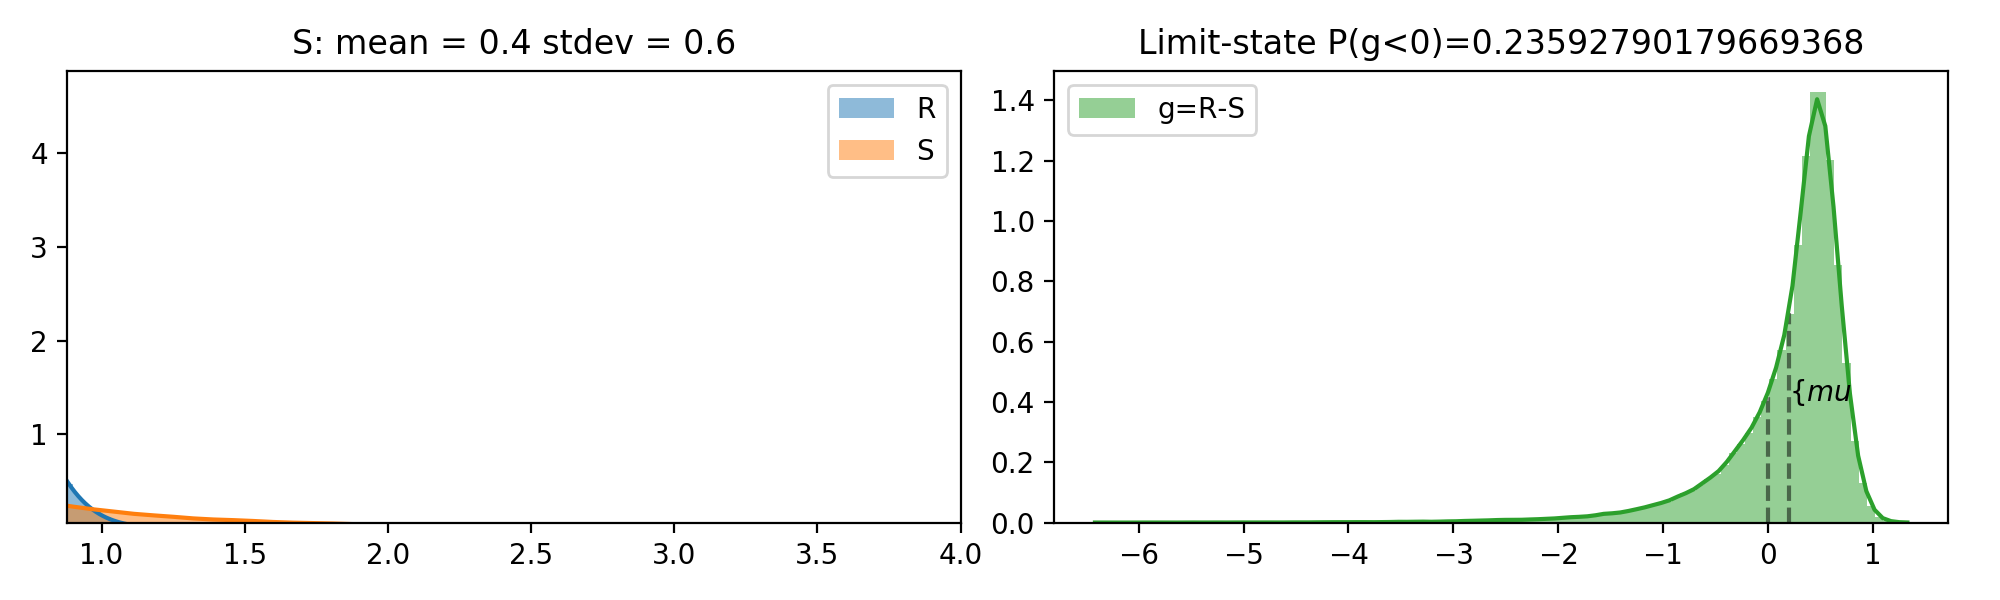

In [20]:
M_cal.run(x = 50.8, t = 40)
M_cal.postproc(plot=True)

In [23]:
plt.savefig('chloride_at_rebar_40year.pdf',dpi=600)

# construction

In [22]:
0.4*pars_raw.cement_concrete_ratio

0.05

In [24]:
t_lis = np.arange(5,50,1)
x_bar = 50.8
M_lis = []
for t in t_lis:
    M_cal.run(x_bar, t)  # [TODO] should be M_cal
    M_cal.postproc()
    M_lis.append(M_cal.copy())

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.2/helper_func.py:368: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  0, S_dropna.max())[0]
/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.2/chloride.py:62: RuntimeWarning: invalid value encountered in sqrt
  C_x_t = pars.C_0 + (pars.C_S_dx - pars.C_0) * (1 - erf((x - pars.dx) / (2 * (pars.D_app * t) ** 0.5)))


<IPython.core.display.Javascript object>


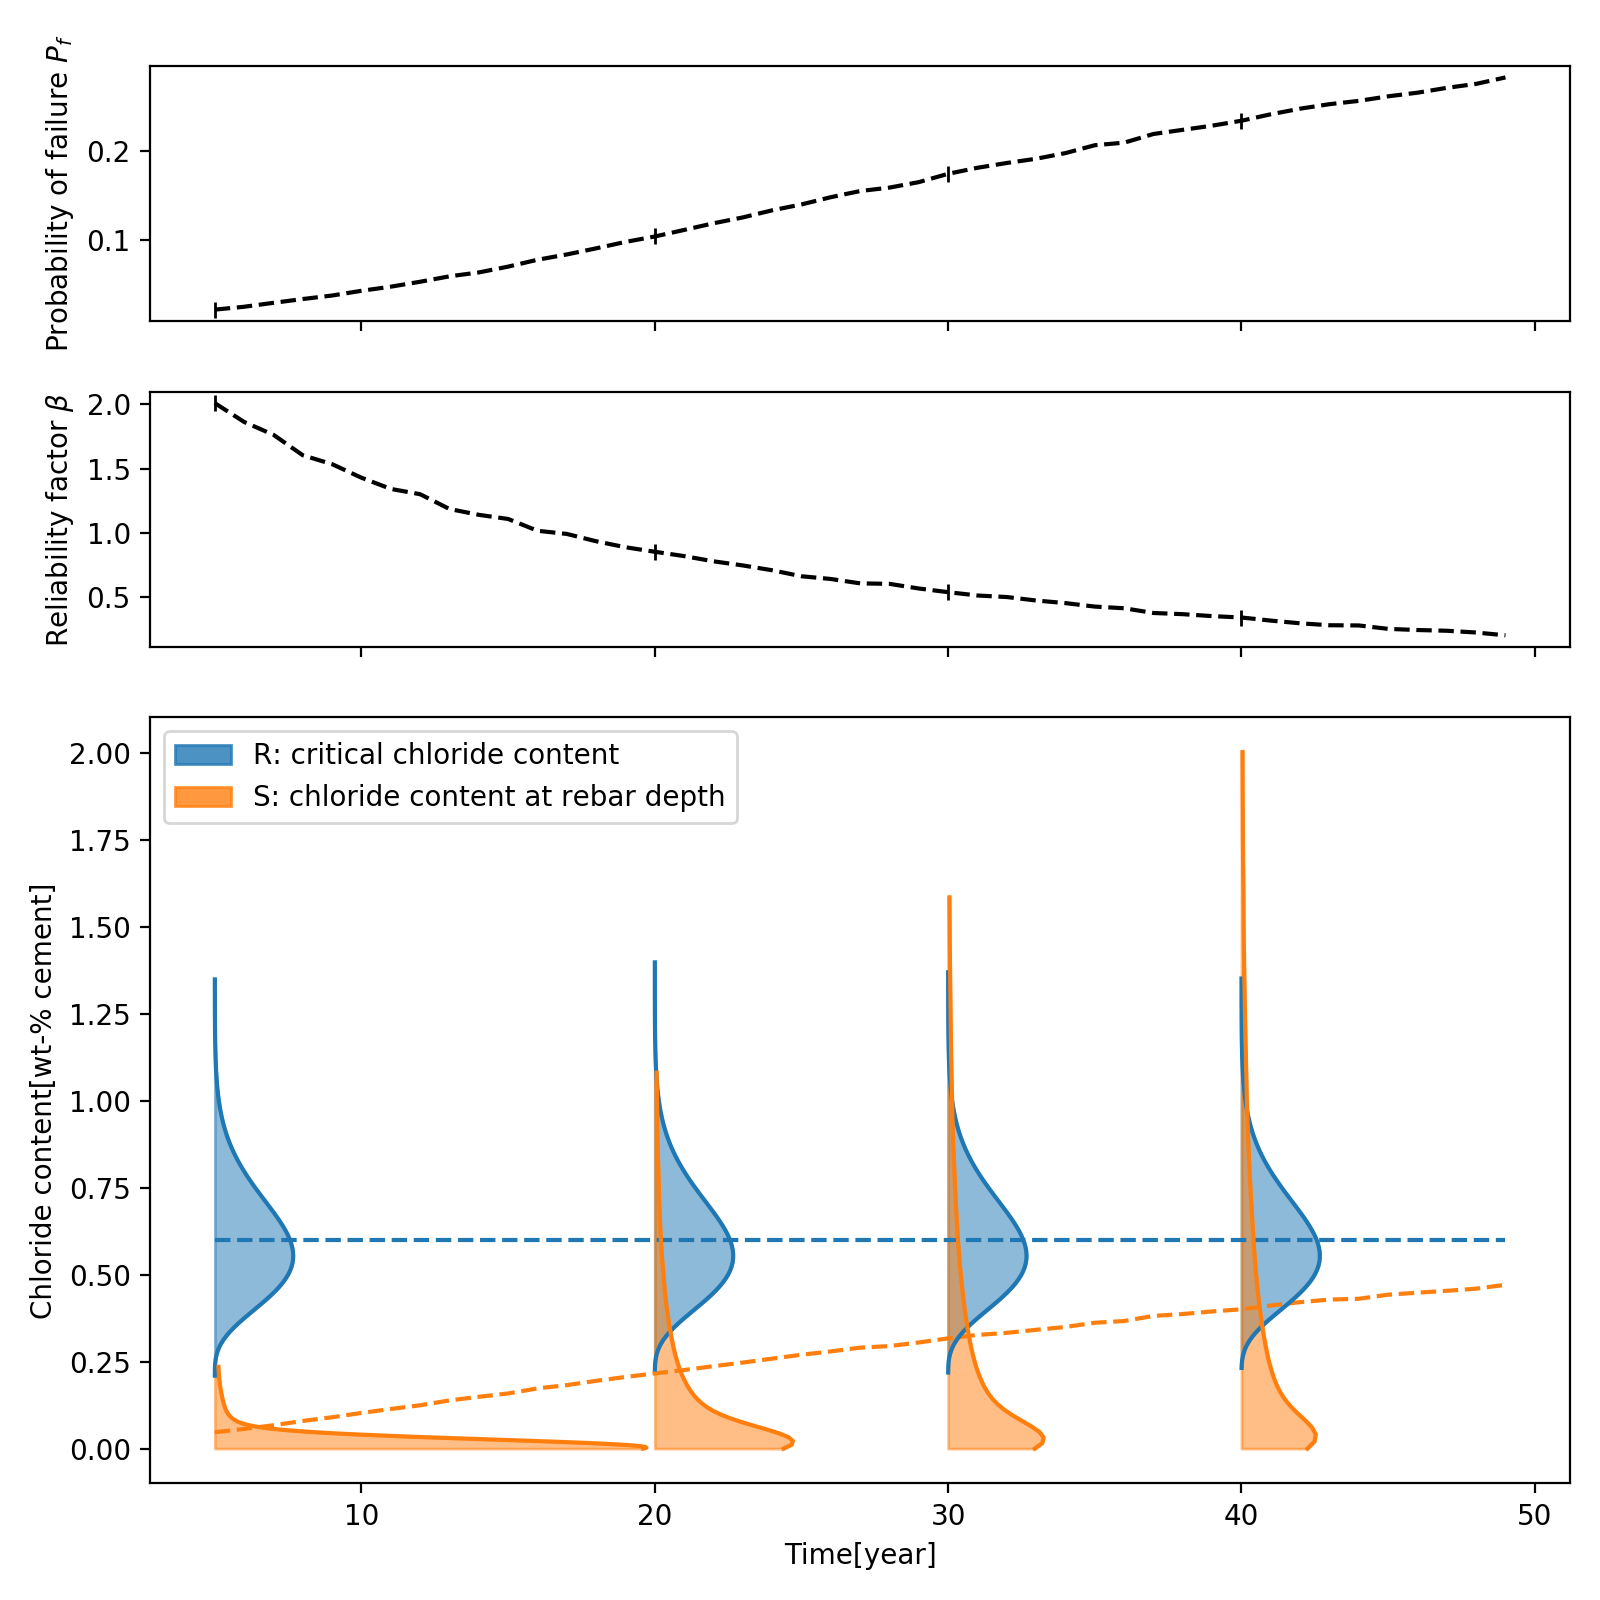

In [26]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows = 3, figsize=(8,8),sharex=True,gridspec_kw={'height_ratios': [1,1,3]})
# plot a few distrubtion
t_plot = np.array([5,20,30,40,50]).astype('float')
indx =  [i for i, val in enumerate(t_lis) if val in set(t_plot)]
M_sel = [M_lis[i] for i in indx]

# M_sel = [M_lis[0],M_lis[20]]
ax1.plot([this_M.t for this_M in M_lis], [this_M.pf for this_M in M_lis],'k--')
ax1.plot([this_M.t for this_M in M_sel], [this_M.pf for this_M in M_sel],'k|')
ax1.set_ylabel('Probability of failure $P_f$')

ax2.plot([this_M.t for this_M in M_lis], [this_M.beta_factor for this_M in M_lis], 'k--')
ax2.plot([this_M.t for this_M in M_sel], [this_M.beta_factor for this_M in M_sel], 'k|')
ax2.set_ylabel(r'Reliability factor $\beta$')
plt.tight_layout()

# plot mean results
ax3.plot(t_lis, [M.pars.C_crit_distrib_param[0] for M in M_lis], '--C0')
ax3.plot(t_lis, [Get_mean(M.C_x_t) for M in M_lis], '--C1')
# plot distribution
for this_M in M_sel:
    RS_plot(this_M, ax=ax3,t_offset=this_M.t, amplify=1)

import matplotlib.patches as mpatches
R_patch = mpatches.Patch(color='C0', label='R: critical chloride content',alpha=0.8)
S_patch = mpatches.Patch(color='C1', label='S: chloride content at rebar depth',alpha=0.8)

ax3.set_xlabel('Time[year]')
ax3.set_ylabel('Chloride content[wt-% cement]')
ax3.legend(handles=[R_patch, S_patch],loc='upper left')

plt.tight_layout()




In [27]:
# fig.savefig('RS_time_chloride.pdf',dpi=600)

